In [2]:
import pandas as pd
import numpy as np
import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats  as stats
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

In [3]:
# 读取数据
ccpp = pd.read_excel('CCPP.xlsx')
ccpp.describe()
# AT-温度  V-压力  AP-相对湿度  RH-排气量  PE-发电量

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


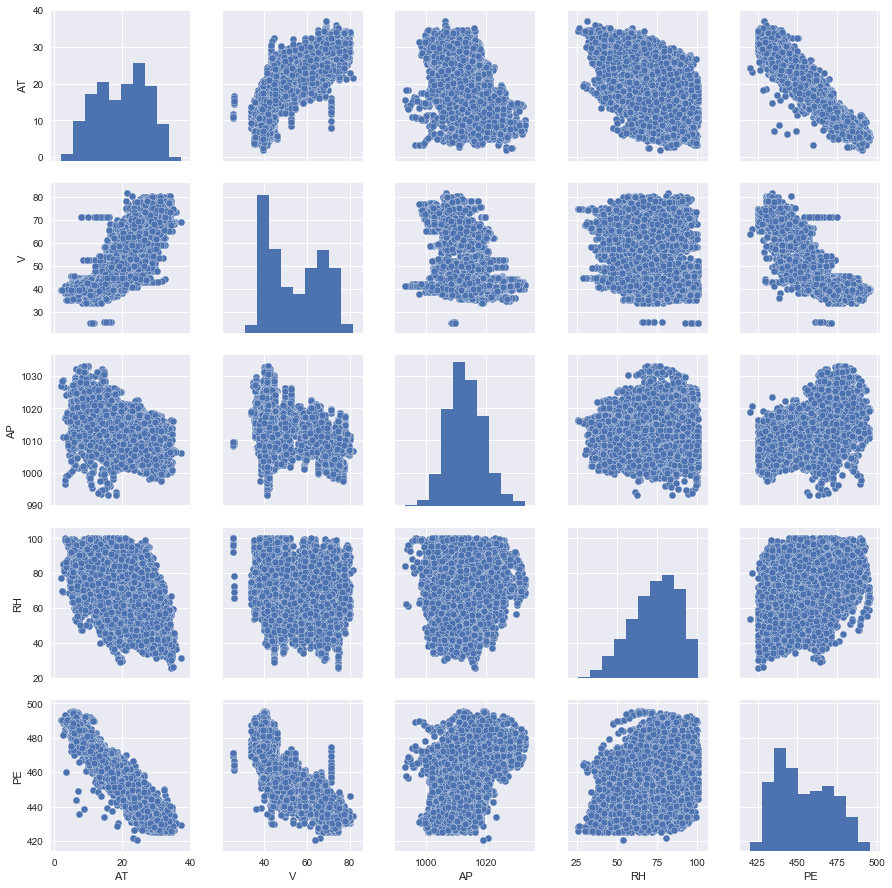

In [4]:
# 绘制各变量之间的散点图
sns.pairplot(ccpp)
plt.show()

In [5]:
# 发电量与自变量之间的相关系数
ccpp.corrwith(ccpp.PE)

AT   -0.948128
V    -0.869780
AP    0.518429
RH    0.389794
PE    1.000000
dtype: float64

In [6]:
## Person_relation >0.6 strong; <0.4 weak; 0.4~0.6 medium;

In [7]:
## 自变量之间多重共线性的检验 使用方差膨胀因子VIF，如果大于10，则说明变量存在多重共线性

In [8]:
# 将因变量PE，自变量AP,V,AP和截距项以数据框的形式组合起来
y,x = patsy.dmatrices('PE~AP+V+AP',data = ccpp, return_type='dataframe')

In [9]:
# 构造空的数据框
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
vif['features'] = x.columns
vif

,VIF Factor,features
0,35868.347927,Intercept
1,1.206249,AP
2,1.206249,V


In [10]:
## 所有自变量的VIF低于10，不存在多重共线性

In [13]:
## 异常点检测
# 构造PE与AP V AP之间的线性模型
fit = sm.formula.ols('PE~AP+V+AP',data=ccpp).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                 1.766e+04
Date:                Wed, 20 Dec 2017   Prob (F-statistic):               0.00
Time:                        15:36:34   Log-Likelihood:                -33325.
No. Observations:                9568   AIC:                         6.666e+04
Df Residuals:                    9565   BIC:                         6.668e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -45.6656     15.255     -2.993      0.003       -75.569   -15.763
AP             0.5504      0.015     36.946      0.000         0.521     0.580
V             -1.0618      0.007   -152.513      0.000        -1.075    -1.048
==============================================================================
Omnibus:                      126.883   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.030
Skew:                           0.170   Prob(JB):                     3.62e-39
Kurtosis:                       3.574   Cond. No.                     1.92e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
# 计算模型的RMSE值
pred = fit.predict()
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(ccpp.PE,pred))

7.8777035275873146

In [14]:
## 异常点检测方法：高杠杆值点（帽子矩阵）或DFFITS值、学生化残差、cook距离和covratio值

In [15]:
# 离群点检验
outliers = fit.get_influence()

# 高杠杆值点（帽子矩阵）
leverage = outliers.hat_matrix_diag
# dffits值
dffits = outliers.dffits[0]
# 学生化残差
resid_stu = outliers.resid_studentized_external
# cook距离
cook = outliers.cooks_distance[0]
# covratio值
covratio = outliers.cov_ratio

# 将上面的几种异常值检验统计量与原始数据集合并
contat1 = pd.concat([pd.Series(leverage, name = 'leverage'),pd.Series(dffits, name = 'dffits'),
                     pd.Series(resid_stu,name = 'resid_stu'),pd.Series(cook, name = 'cook'),
                     pd.Series(covratio, name = 'covratio'),],axis = 1)
ccpp_outliers = pd.concat([ccpp,contat1], axis = 1)
ccpp_outliers.head()

,AT,V,AP,RH,PE,leverage,dffits,resid_stu,cook,covratio
0,14.96,41.76,1024.07,73.17,463.26,0.000458,-0.028193,-1.317294,0.000265,1.000227
1,25.18,62.96,1020.04,59.08,444.37,0.000408,-0.011646,-0.576110,0.000045,1.000618
2,5.11,39.40,1012.16,92.14,488.56,0.000305,0.042075,2.409074,0.000590,0.998799
3,20.86,57.32,1010.24,76.64,446.48,0.000132,-0.004402,-0.383680,0.000006,1.000399
4,10.82,37.50,1009.23,96.62,473.90,0.000477,0.010835,0.496177,0.000039,1.000713


In [16]:
## 通过参考薛毅老师的《统计建模与R软件》书可知，当高杠杆值点（或帽子矩阵）大于2(p+1)/n时，则认为该样本点可能存在异常（其中p为自变量的个数，n为观测的个数）；当DFFITS统计值大于2sqrt((p+1)/n)时 ，则认为该样本点可能存在异常；当学生化残差的绝对值大于2，则认为该样本点可能存在异常；对于cook距离来说，则没有明确的判断标准，一般来说，值越大则为异常点的可能性就越高；对于covratio值来说，如果一个样本的covratio值离数值1越远，则认为该样本越可能是异常值。这里我们就以学生化残差作为评判标准，因为其包含了帽子矩阵和DFFITS的信息。

In [18]:
# 计算异常值数量的比例
outlier_ratio = sum(np.where((np.abs(ccpp_outliers.resid_stu)>2),1,0))/ccpp_outliers.shape[0]
outlier_ratio

0.04964464882943144

In [19]:
# 删除异常值
ccpp_outliers = ccpp_outliers.loc[np.abs(ccpp_outliers.resid_stu)<=2,]

In [21]:
# 重新建模
fit2 = sm.formula.ols('PE~AT+V+AP',data = ccpp_outliers).fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 3.684e+04
Date:                Wed, 20 Dec 2017   Prob (F-statistic):               0.00
Time:                        16:00:07   Log-Likelihood:                -26624.
No. Observations:                9093   AIC:                         5.326e+04
Df Residuals:                    9089   BIC:                         5.328e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    287.0322      9.746     29.451      0.000       267.928   306.137
AT            -1.4412      0.014   -103.449      0.000        -1.468    -1.414
V             -0.4033      0.007    -54.411      0.000        -0.418    -0.389
AP             0.2146      0.010     22.489      0.000         0.196     0.233
==============================================================================
Omnibus:                       31.699   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.157
Skew:                           0.115   Prob(JB):                     2.83e-07
Kurtosis:                       2.837   Cond. No.                     2.09e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# 计算模型的RMSE值
pred2 = fit2.predict()
np.sqrt(mean_squared_error(ccpp_outliers.PE, pred2))

4.5222094908258219

In [23]:
## AIC和BIC 均变小，同时RMSE值降低

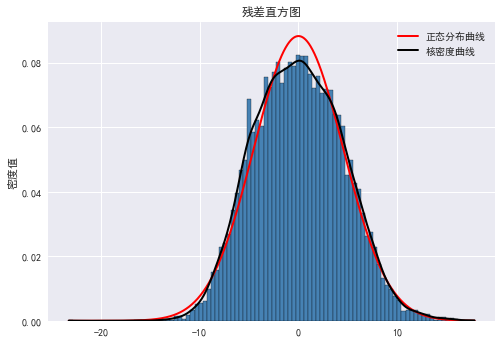

In [25]:
### 正态性检验
# 残差的正态性检验（直方图法）
resid = fit2.resid

# 中文和负号的正常显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.hist(resid, # 绘图数据
        bins = 100, # 指定直方图条的个数
        normed = True, # 设置为频率直方图
        color = 'steelblue', # 指定填充色
        edgecolor = 'k') # 指定直方图的边界色

# 设置坐标轴标签和标题
plt.title('残差直方图')
plt.ylabel('密度值')

# 生成正态曲线的数据
x1 = np.linspace(resid.min(), resid.max(), 1000)
normal = mlab.normpdf(x1, resid.mean(), resid.std())

# 绘制正态分布曲线
plt.plot(x1,normal,'r-', linewidth = 2, label = '正态分布曲线') 

# 生成核密度曲线的数据
kde = mlab.GaussianKDE(resid)
x2 = np.linspace(resid.min(), resid.max(), 1000)

# 绘制核密度曲线
plt.plot(x2,kde(x2),'k-', linewidth = 2, label = '核密度曲线')

# 去除图形顶部边界和右边界的刻度
plt.tick_params(top='off', right='off')

# 显示图例
plt.legend(loc='best')
# 显示图形
plt.show()

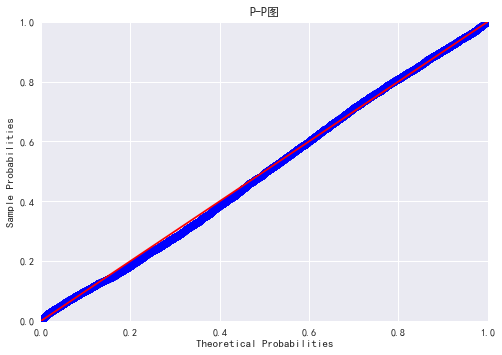

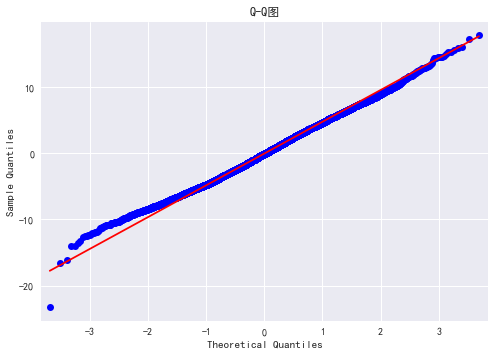

In [28]:
# 残差的正态性检验（PP图和QQ图法）
pp_qq_plot = sm.ProbPlot(resid)

pp_qq_plot.ppplot(line = '45')
plt.title('P-P图')

pp_qq_plot.qqplot(line = 'q')
plt.title('Q-Q图')
# 显示图形
plt.show()

In [29]:
# 残差的正态性检验（非参数法）
standard_resid = (resid-np.mean(resid))/np.std(resid)
stats.kstest(standard_resid, 'norm')

KstestResult(statistic=0.021423691885827933, pvalue=0.00047425546651597481)

In [30]:
## 由于shapiro正态性检验对样本量的要求是5000以内；而本次数据集的样本量由9000多，故选择K-S来完成正态性检验。从K-S检验的P值来看，拒绝了残差服从正态分布的假设，即认为残差并不满足正态性假设这个前提。

In [34]:
### 残差方差齐性检验

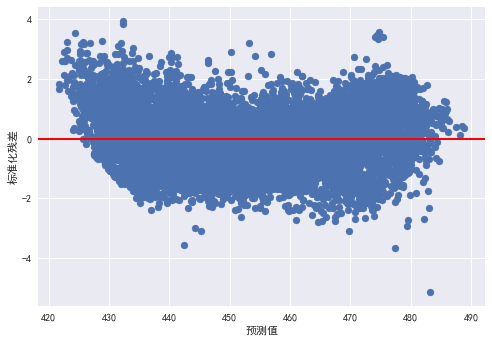

In [35]:
# ====== 图示法完成方差齐性的判断 ======
# 标准化残差与预测值之间的散点图
plt.scatter(fit2.predict(), (fit2.resid-fit2.resid.mean())/fit2.resid.std())
plt.xlabel('预测值')
plt.ylabel('标准化残差')

# 添加水平参考线
plt.axhline(y = 0, color = 'r', linewidth = 2)
plt.show()

In [36]:
# ====== 统计法完成方差齐性的判断 ======
# White's Test
sm.stats.diagnostic.het_white(fit2.resid, exog = fit2.model.exog)
# Breusch-Pagan
sm.stats.diagnostic.het_breushpagan(fit2.resid, exog_het = fit2.model.exog)

(35.675145485123814,
 8.7712643006014068e-08,
 11.933302695981665,
 8.5337279373729728e-08)

In [37]:
# 从检验结果来看，不论是White检验还是Breush-Pagan检验，P值都远远小于0.05这个判别界限，即拒绝原假设（残差方差为常数的原假设），认为残差并不满足齐性这个假设。

In [38]:
### 残差独立性检验

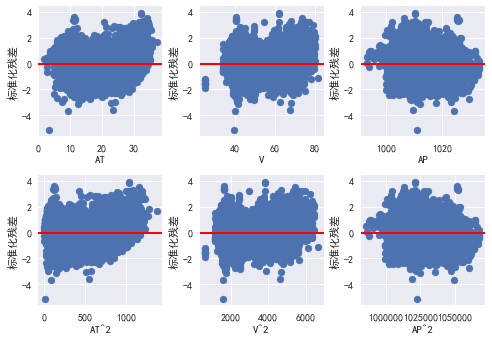

In [41]:
# ===== 残差与x的关系 =====
plt.subplot(231)    
plt.scatter(ccpp_outliers.AT, (fit2.resid-fit2.resid.mean())/fit2.resid.std())
plt.xlabel('AT')
plt.ylabel('标准化残差')
plt.axhline(color = 'red', linewidth = 2)

plt.subplot(232)    
plt.scatter(ccpp_outliers.V, (fit2.resid-fit2.resid.mean())/fit2.resid.std())
plt.xlabel('V')
plt.ylabel('标准化残差')
plt.axhline(color = 'red', linewidth = 2)

plt.subplot(233)    
plt.scatter(ccpp_outliers.AP, (fit2.resid-fit2.resid.mean())/fit2.resid.std())
plt.xlabel('AP')
plt.ylabel('标准化残差')
plt.axhline(color = 'red', linewidth = 2)

plt.subplot(234)    
plt.scatter(np.power(ccpp_outliers.AT,2), (fit2.resid-fit2.resid.mean())/fit2.resid.std())
plt.xlabel('AT^2')
plt.ylabel('标准化残差')
plt.axhline(color = 'red', linewidth = 2)

plt.subplot(235)    
plt.scatter(np.power(ccpp_outliers.V,2), (fit2.resid-fit2.resid.mean())/fit2.resid.std())
plt.xlabel('V^2')
plt.ylabel('标准化残差')
plt.axhline(color = 'red', linewidth = 2)

plt.subplot(236)    
plt.scatter(np.power(ccpp_outliers.AP,2), (fit2.resid-fit2.resid.mean())/fit2.resid.std())
plt.xlabel('AP^2')
plt.ylabel('标准化残差')
plt.axhline(color = 'red', linewidth = 2)

# 设置子图之间的水平间距和高度间距
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

In [43]:
# 三种权重
w1 = 1/np.abs(fit2.resid)
w2 = 1/fit2.resid**2
ccpp_outliers['loge2'] = np.log(fit2.resid**2)
# 第三种权重
model = sm.formula.ols('loge2~AT+V+AP', data = ccpp_outliers).fit()
w3 = 1/(np.exp(model.predict()))

# 建模
fit3 = sm.formula.wls('PE~AT+V+AP', data = ccpp_outliers, weights = w1).fit()
# 异方差检验
het3 = sm.stats.diagnostic.het_breushpagan(fit3.resid, exog_het = fit3.model.exog)
# AIC
fit3.aic

fit4 = sm.formula.wls('PE~AT+V+AP', data = ccpp_outliers, weights = w2).fit()
het4 = sm.stats.diagnostic.het_breushpagan(fit4.resid, exog_het = fit4.model.exog)
fit4.aic

fit5 = sm.formula.wls('PE~AT+V+AP', data = ccpp_outliers, weights = w3).fit()
het5 = sm.stats.diagnostic.het_breushpagan(fit5.resid, exog_het = fit5.model.exog)
fit5.aic

# fit2模型
het2 = sm.stats.diagnostic.het_breushpagan(fit2.resid, exog_het = fit2.model.exog)
fit2.aic

print('fit2模型异方差检验统计量：%.2f，P值为%.4f：' %(het2[0],het2[1]))
print('fit3模型异方差检验统计量：%.2f，P值为%.4f：' %(het3[0],het3[1]))
print('fit4模型异方差检验统计量：%.2f，P值为%.4f：' %(het4[0],het4[1]))
print('fit5模型异方差检验统计量：%.2f，P值为%.4f：\n' %(het5[0],het5[1]))

print('fit2模型的AIC：%.2f' %fit2.aic)
print('fit3模型的AIC：%.2f' %fit3.aic)
print('fit4模型的AIC：%.2f' %fit4.aic)
print('fit5模型的AIC：%.2f' %fit5.aic)

fit2模型异方差检验统计量：35.68，P值为0.0000：
fit3模型异方差检验统计量：40.27，P值为0.0000：
fit4模型异方差检验统计量：35.67，P值为0.0000：
fit5模型异方差检验统计量：45.26，P值为0.0000：

fit2模型的AIC：53255.50
fit3模型的AIC：46001.23
fit4模型的AIC：42513.92
fit5模型的AIC：53229.19


In [44]:
### 残差独立性检验

In [45]:
## 在模型的summary信息中就包含了残差的Durbin-Watson统计量值，如果该值越接近于2，则说明残差是独立。

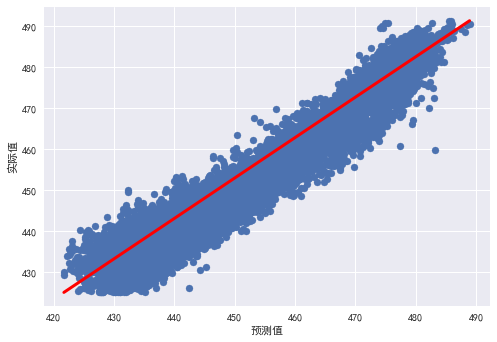

In [46]:
# 预测值与真实值的散点图
plt.scatter(fit4.predict(), ccpp_outliers.PE)
plt.plot([fit4.predict().min(),fit4.predict().max()], 
         [ccpp_outliers.PE.min(), ccpp_outliers.PE.max()], 
         'r-', linewidth = 3)
plt.xlabel('预测值')
plt.ylabel('实际值')
# 显示图形
plt.show()